# Buildings network

In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as patches
mpl.rc('text', usetex=True)
plt.rcParams.update({'font.size': 22})
import shapely
import sec

## Load the buildings from OpenStreetMap

#### Option 1: load the buildings within some distance north, south, east, and west of a lat-long point.

In [4]:
point_coords = (45.745591, 4.871167) # latitude and longitude of montplaisir-Lumière, Lyon (France)
distance = 1000 # in meters

B = ox.buildings_from_point(point_coords, distance=distance)

#### Option 2: load the buildings within the boundaries of some place.

In [ ]:
# uncomment to load buildings from place
# B = ox.buildings_from_place('Lyon')

#### Project into planar coordinates:

In [9]:
B.crs

{'init': 'epsg:4326'}

In [10]:
B = ox.project_gdf(B) # pass from angular (lat, long) coords to planar coords

In [11]:
B.crs

{'datum': 'WGS84', 'ellps': 'WGS84', 'proj': 'utm', 'units': 'm', 'zone': 31}

<Figure size 720x720 with 0 Axes>

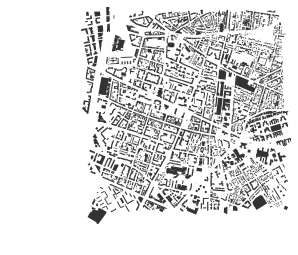

In [12]:
plt.figure(figsize=(10,10))
fig, ax = ox.plot_buildings(B)

## Define the *Building network* nodes

To simplify the geometry:
- merge blocks of buildings (adjacent buildings)
- take the convex hull

When taking the convex hull, some new intersections can form. Iteratively merge and take the convex hull until no intersections are found (i.e., until the number of buildings remains the same).

Unary_union does not merge polygons that share only one vertex. To avoid this, I dilate all polygons of a small quantity.

In [13]:
buffer = 0.01 # 1 cm
B = B.geometry.buffer(buffer)

In [14]:
def merge_and_convex(df):
    go = True
    length = len(df)
    i = 0
    print(i, length)
    while go:
        i += 1
        df = gpd.GeoDataFrame(geometry=list(df.unary_union)).convex_hull
        print(i, len(df))
        if len(df) == length:
            go = False
        else:
            length = len(df)
    return df

In [15]:
B = merge_and_convex(B)

0 5578
1 1937
2 1511
3 1392
4 1353
5 1335
6 1325
7 1315
8 1311
9 1309
10 1307
11 1306
12 1306


<Figure size 720x720 with 0 Axes>

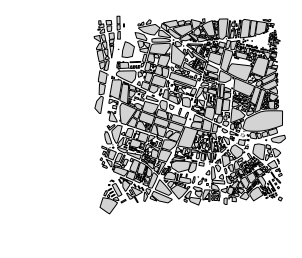

In [16]:
plt.figure(figsize=(10,10))
B.plot(color='lightgray', edgecolor='black')
plt.axis('off')
plt.show()

Each (merged) building corresponds to one node.

#### Visualize nodes:

In [17]:
nodes = B.centroid

In [18]:
buildings_df = gpd.GeoDataFrame(geometry=[build for build in B])

In [19]:
col = [1 for build in B] + [2 for node in nodes]
nodes_df = gpd.GeoDataFrame(col, geometry=[build for build in B] + [node for node in nodes],
                           columns=['color'])

In [20]:
colors = ['lightgray', 'black']

In [21]:
from matplotlib.colors import ListedColormap
cm = ListedColormap(colors, N=len(colors))

<Figure size 720x720 with 0 Axes>

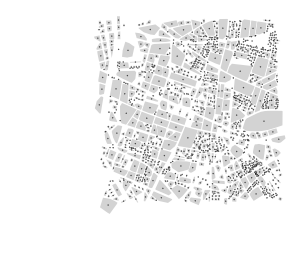

In [22]:
plt.figure(figsize=(10,10))
nodes_df.plot(figsize=(10, 10), column='color', markersize=0.1, cmap=cm)
plt.axis('off')
plt.show()

## Define the *Building network* links

Two nodes are connected if they have at least a couple of points at distance < distance_threshold.

In [23]:
distance_threshold = 30 # in meters

NOTE: the distance threshold is applied after buffering (but of a very small quantity!)

Definition of the pairwise weights:

For a given link $(b_i, b_j)$:

- buffer $b_i$ of distance equal to the distance threshold used to determine the links
- calculate the area $A_i$ of intersection with $b_j$
- same for $b_j$
- sum the two areas

$$w_{b_i, b_j} = A_i + A_j$$

In [24]:
def pairwise_weight(i, j, buildings, nodes, distance_threshold):
    b_i = buildings.iloc[i]['geometry']
    b_j = buildings.iloc[j]['geometry']
    n_i = nodes.iloc[i]
    n_j = nodes.iloc[j]
    b_i_buffered = b_i.buffer(distance_threshold)
    b_j_buffered = b_j.buffer(distance_threshold)
    area1 = b_i_buffered.intersection(b_j).area
    area2 = b_j_buffered.intersection(b_i).area
    wij = area1 + area2
    return wij

Define links:

In [25]:
edges = set([])
weights = {}
for i, b_i in enumerate(B):
    node_i = nodes.iloc[i]
    neighbors = []
    for j, b_j in enumerate(B.iloc[i+1::], start=i+1):
        dist = b_i.distance(b_j)
        if dist < distance_threshold:
            edges.add((i, j))
            neighbors.append(j)
            wij = pairwise_weight(i, j, buildings_df, nodes, distance_threshold)
            weights[(i, j)] = wij
            
    for k in neighbors:
        node_k = nodes.iloc[k]
        segment = shapely.geometry.LineString([list(node_i.coords)[0], list(node_k.coords)[0]])
        stop = False
        for q in neighbors[k+1::]:
            if not stop:
                b_q = B.iloc[q]
                if not b_q.intersection(segment).is_empty:
                    edges.remove((i, k))
                    weights.pop((i, k))
                    stop = True
            else: break
    

#### Visualize links:

In [26]:
edges_segment = []
for u, v in edges:
    node_u = nodes.iloc[u]
    node_v = nodes.iloc[v]
    edge_segment = shapely.geometry.LineString([list(node_u.coords)[0], list(node_v.coords)[0]])
    edges_segment.append(edge_segment)

In [27]:
colors = [2 for build in B] + [1 for edge in edges_segment] + [3 for node in nodes]

In [28]:
df = gpd.GeoDataFrame(colors, geometry = [build for build in B] + edges_segment + 
                      [node for node in nodes], columns=['color'])

<Figure size 432x288 with 0 Axes>

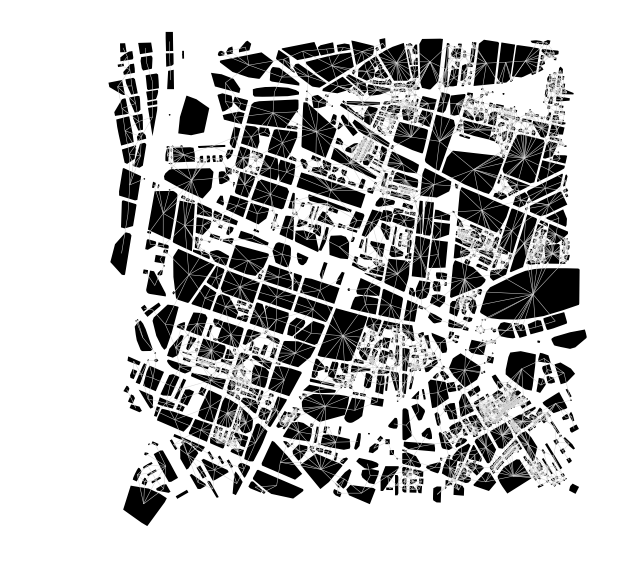

In [29]:
plt.figure()
df.plot(figsize=(10, 10), column='color', markersize=1, linewidth=0.5, cmap=cm)
plt.axis('off')
plt.show()

## Create the *Buildings network* graph:

In [30]:
G = nx.Graph()
pos = {}
for index, node in enumerate(nodes):
    G.add_node(index)
    pos[index] = list(node.coords)[0]
for u, v in edges:
    G.add_edge(u, v)
    
nx.set_edge_attributes(G, weights, name='weight')

Remove isolated nodes:

In [31]:
degrees_zero = []
for node in G.nodes:
    k = nx.degree(G, node)
    if k == 0:
        degrees_zero.append(node)

G.remove_nodes_from(degrees_zero)

### Visualize the buildings network:

#### Node color: value of neighborhood watch (w/k)

In [32]:
neigh_watch_sharp = []
for index, node in enumerate(G.nodes):
    k = nx.degree(G, node)
    w = nx.degree(G, node, weight='weight')
    nw = w / k
    
    if nw < 500:
        neigh_watch_sharp.append(1)
    elif nw < 1000:
        neigh_watch_sharp.append(2)
    elif nw < 1500:
        neigh_watch_sharp.append(3)
    elif nw < 2000:
        neigh_watch_sharp.append(4)
    elif nw < 2500:
        neigh_watch_sharp.append(5)
    else:
        neigh_watch_sharp.append(6)

In [33]:
colors = ['blue', 'cyan', 'greenyellow', 'yellow', 'orange', 'red']
node_color = [colors[value - 1] for value in neigh_watch_sharp]

In [34]:
weights_values = [weights[(u, v)] for u, v in G.edges]

C:\Users\Lorenza\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


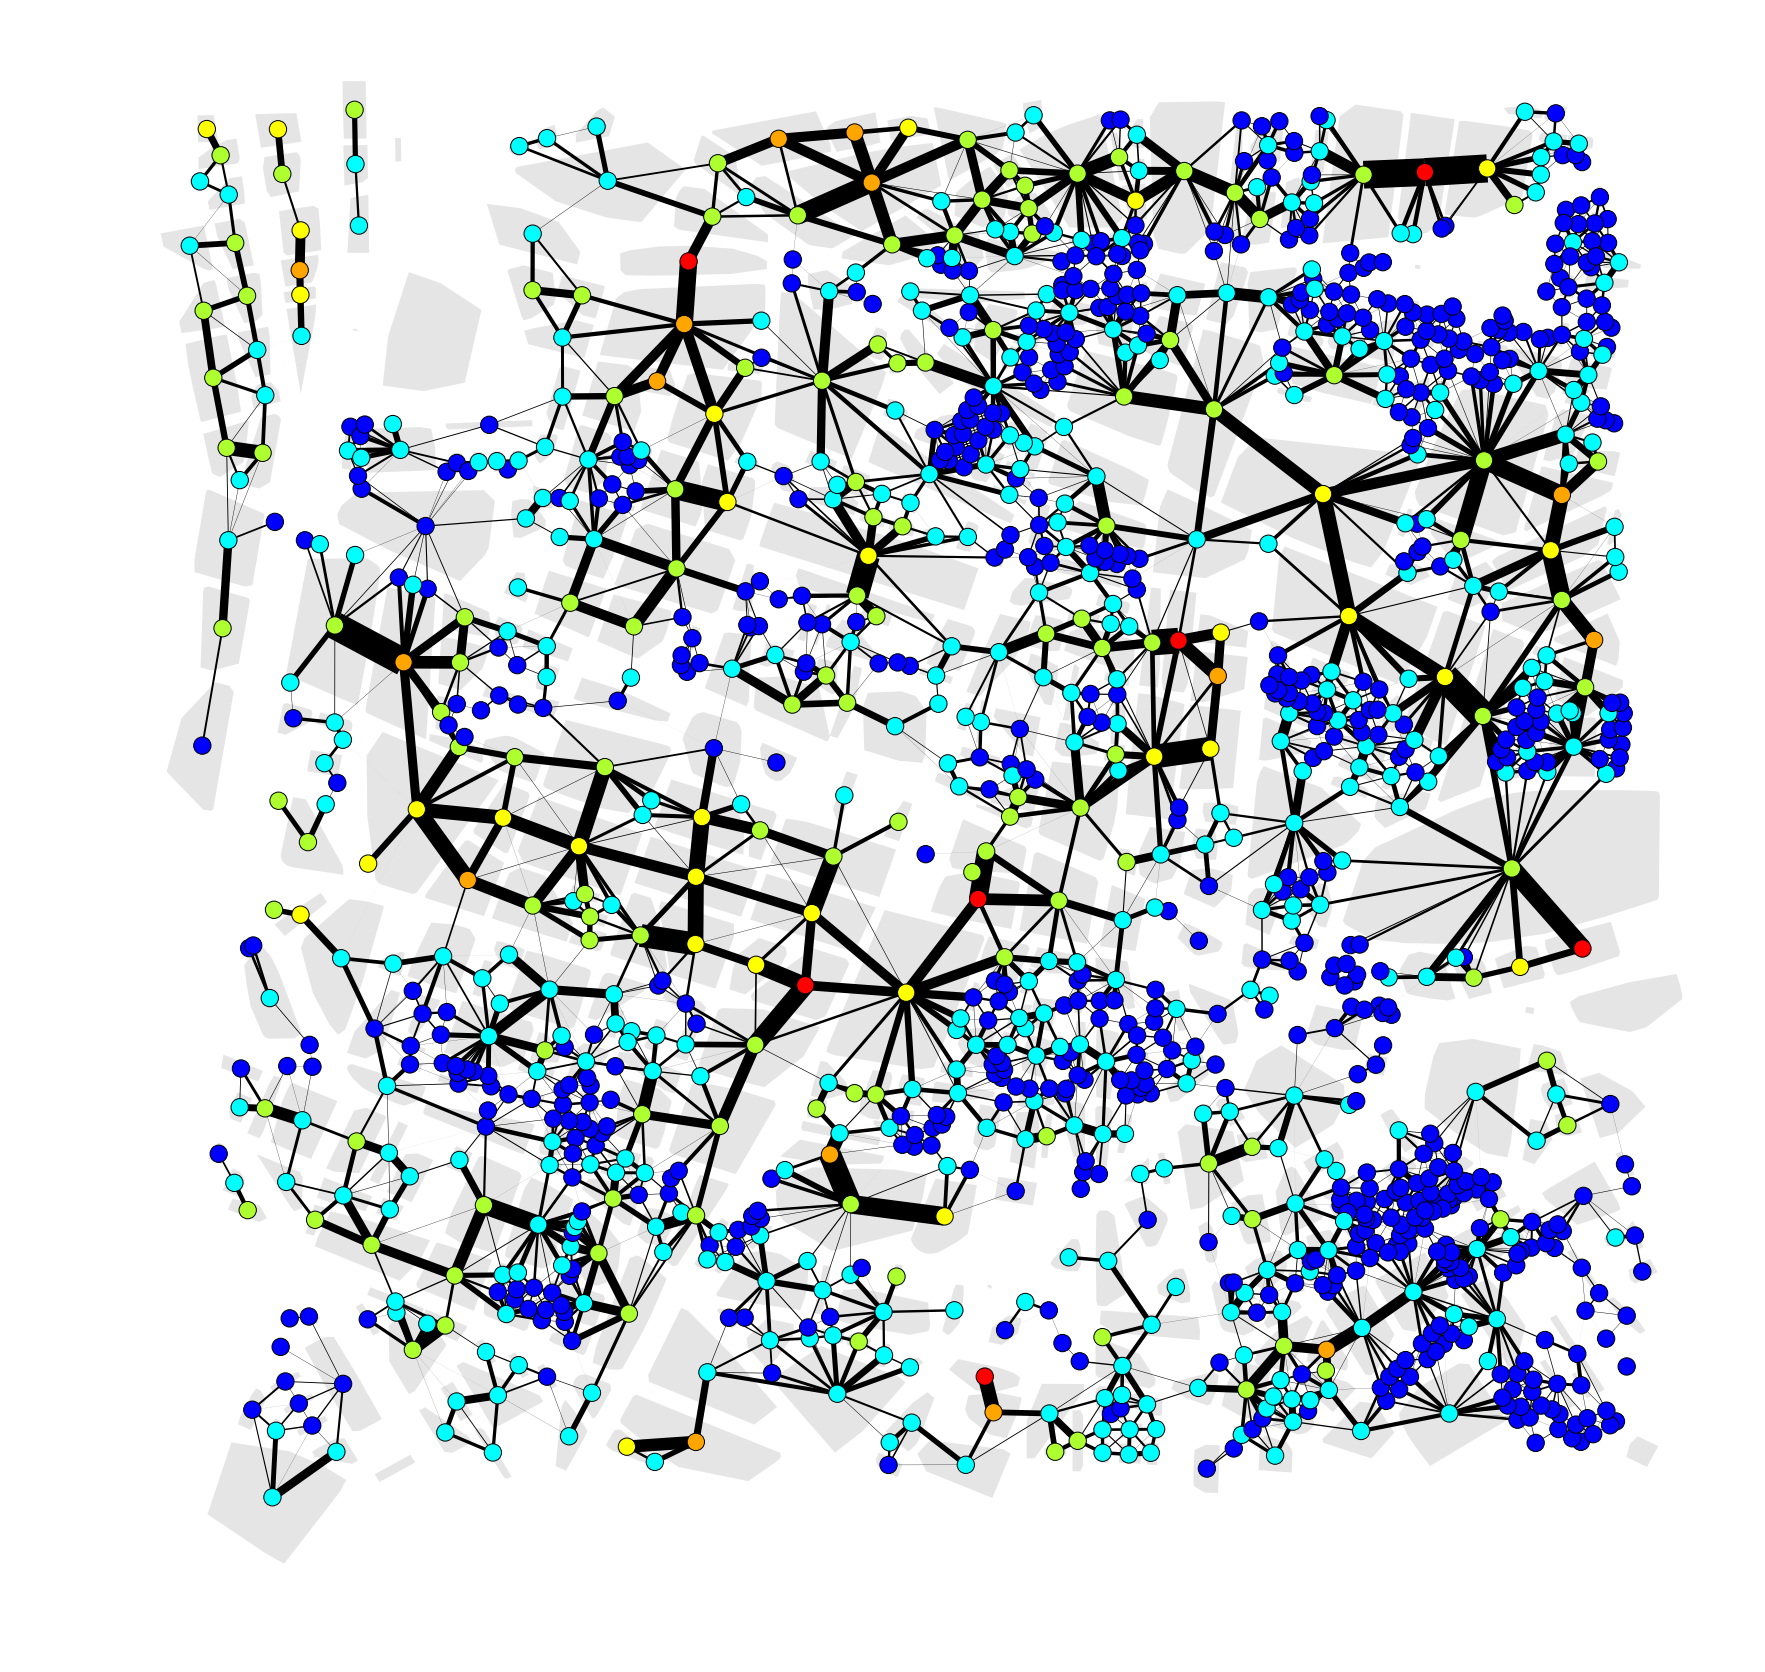

In [35]:
fig, ax  = plt.subplots(figsize=(30, 30))
base = buildings_df.plot(ax=ax, color='gray', alpha=0.2)
nx.draw_networkx_nodes(G, pos=pos, with_labels=False, node_color=node_color, edgecolors='k', ax=ax)
nx.draw_networkx_edges(G, pos=pos, width=[w * (2) ** (-8) for w in weights_values], ax=ax)
plt.axis('off')
plt.show()

Legend:

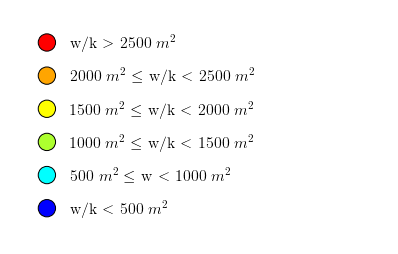

In [36]:
Glegend = nx.Graph()
for n in range(1, 7):
    Glegend.add_node(str(n))

poslegend = {}
for i, node in enumerate(Glegend.nodes):
    poslegend[node] = np.array([0, i + 0.15])

plt.figure() 
nx.draw_networkx_nodes(Glegend, poslegend, node_color=colors,edgecolors='k')
plt.axis('off')
plt.xlim(-0.2, 3)
plt.ylim(-0.2, 6)
plt.rc('text', usetex=True)
plt.rc('font', family='calibri')
plt.text(0.2, 0, 'w/k $<$ 500 $m^2$',fontsize=16)
plt.text(0.2, 1, '500 ${m}^2$ $\leq$ w $<$ 1000 ${m}^2$',fontsize=16)
plt.text(0.2, 2, '1000 ${m}^2$ $\leq$ w/k $<$ 1500 ${m}^2$',fontsize=16)
plt.text(0.2, 3, '1500 ${m}^2$ $\leq$ w/k $<$ 2000 ${m}^2$',fontsize=16)
plt.text(0.2, 4, '2000 ${m}^2$ $\leq$ w/k $<$ 2500 ${m}^2$',fontsize=16)
plt.text(0.2, 5, 'w/k $>$ 2500 ${m}^2$',fontsize=16)
plt.show()
plt.close()

In [37]:
pairwise_sharp = []
for wij in weights_values:
    if wij < 500: pairwise_sharp.append(1)
    elif wij < 1000:  pairwise_sharp.append(2)
    elif wij < 1500:  pairwise_sharp.append(3)
    elif wij < 2000:  pairwise_sharp.append(4)
    elif wij < 2500:  pairwise_sharp.append(5)
    else: pairwise_sharp.append(6)

#### Edge color: link weight

In [38]:
edge_color = [colors[value - 1] for value in pairwise_sharp]

C:\Users\Lorenza\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


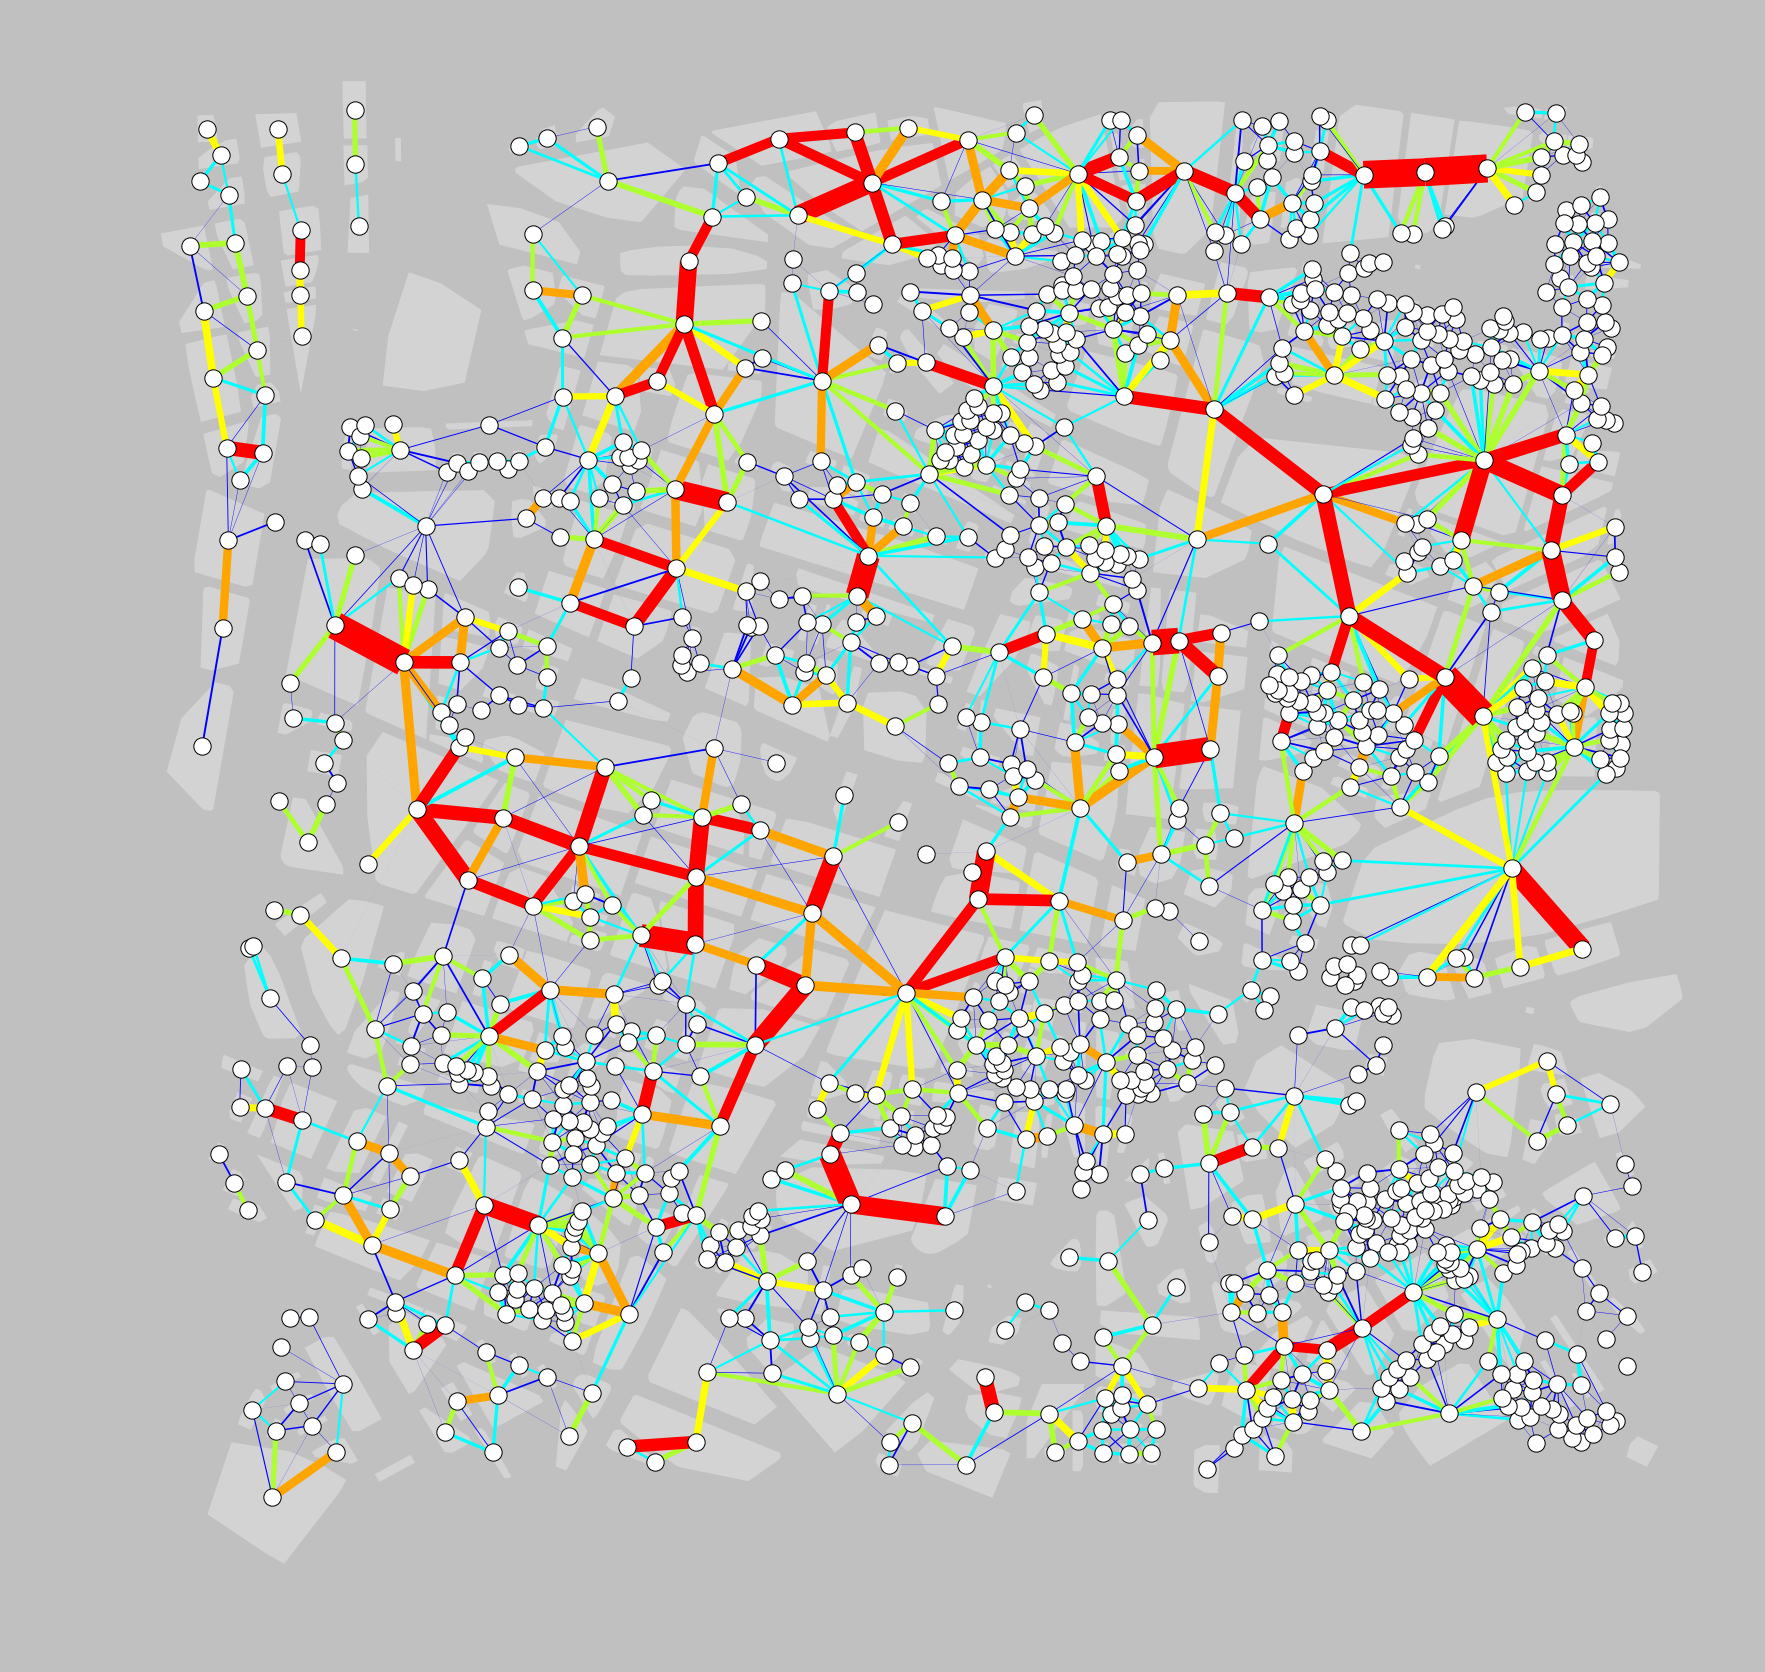

In [39]:
facecolor='silver'
fig, ax  = plt.subplots(figsize=(30, 30), facecolor=facecolor)
base = buildings_df.plot(ax=ax, color='white', alpha=0.3)
nx.draw_networkx_nodes(G, pos=pos, with_labels=False, edgecolors='k', node_color='w')
nx.draw_networkx_edges(G, pos=pos, width=[w * (2) ** (-8) for w in weights_values], edge_color=edge_color)
plt.axis('off')
plt.show()

Legend:

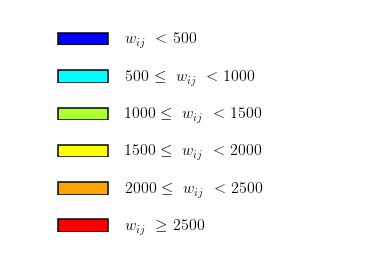

In [73]:
texts = ['$w_{ij} \  <$ 500', '500 $\leq \ w_{ij} \  <$ 1000', '1000 $\leq \ w_{ij} \  <$ 1500',
         '1500 $\leq \ w_{ij} \  <$ 2000', '2000 $\leq \ w_{ij} \  <$ 2500', '$w_{ij} \  \geq$ 2500']
fig = plt.figure()
plt.rc('text', usetex=True)
plt.rc('font', family='calibri')
for index, c in enumerate(colors):
    subf = int('61%s' %(index + 1))
    ax1 = fig.add_subplot(subf)
    ax1.add_patch(patches.Rectangle((0.1, 0), 0.15, .4, facecolor=c, edgecolor='k',
                                    linewidth=1.5))
    ax1.axis('off')
    ax1.text(0.3, 0, texts[index], fontsize=16)
plt.axis('off')
plt.show()